In [1]:
import json
import sys
import numpy as np
from numpy import log, exp, pi
import pandas as pd
import scipy
import scipy.stats as stats
import random
from scipy.stats import gaussian_kde, loguniform
from math import lgamma
from glob import glob
import os
#import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

path = '/Users/chris/Desktop/sculpting/'

In [2]:
berger_kepler = pd.read_csv(path+'berger_kepler_stellar17.csv') # crossmatched with Gaia via Bedell
print(len(berger_kepler))
print(berger_kepler.head())

19969
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
1  892667  2MASS J19243045+3637186  6609      159.0     -227.0  4.105   
2  892678  2MASS J19243108+3638316  6137      167.0     -186.0  3.936   
3  892713  2MASS J19243353+3637220  6106      186.0     -186.0  3.854   
4  892828  2MASS J19243904+3637166  6691      188.0     -235.0  4.134   

   logg_err1  logg_err2  feh_x  feh_err1  ...  parallax  parallax_err  feh_y  \
0      0.258     -0.172  -0.24      0.25  ...    1.2137        0.0220    NaN   
1      0.246     -0.164  -0.26      0.25  ...    0.8512        0.0154    NaN   
2      0.428     -0.143  -0.26      0.30  ...    1.0236        0.0259    NaN   
3      0.496     -0.124  -0.24      0.30  ...    0.9602        0.0231    NaN   
4      0.209     -0.171  -0.26      0.25  ...    0.9660        0.0143    NaN   

   feh_err    RUWE  num_gaia_companions  Kmag_final_prov  evstate      log

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (138) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# transit multiplicity from Kepler/Gaia Berger et al 2020, plus Bedell, plus Exoplanet Archive
# see isolate_with_bedell.ipynb
pnum = pd.read_csv(path+'pnum_plus_cands.csv')
print(len(pnum))
pnum = pnum.drop_duplicates(['kepid'])
print(len(pnum))
k = pnum.koi_count.value_counts() 
k = pd.Series([len(berger_kepler)-np.sum(k), 244, 51, 12, 8, 1]) 
print(k)

408
316
0    19653
1      244
2       51
3       12
4        8
5        1
dtype: int64


In [4]:
import csv
from ast import literal_eval

with open('simulations_w_geometric_transits.csv','r') as csvfile:
    read_csv = csv.reader(csvfile, delimiter='\t')
    read_csv=list(read_csv)

df = pd.DataFrame(read_csv[1:], columns=read_csv[0])
df.lams = df.lams.apply(literal_eval) # convert back from string to list of floats
df.geometric_lams = df.geometric_lams.apply(literal_eval)
df.logLs = df.logLs.apply(literal_eval)
df.geometric_logLs = df.geometric_logLs.apply(literal_eval)
df.bs = df.bs.apply(literal_eval)
df.ms = df.ms.apply(literal_eval)

df.intact_fracs = df.intact_fracs.apply(literal_eval)
geom_logLs = df.geometric_logLs
geom_lams = df.geometric_lams
logLs = df.logLs
lams = df.lams
print(df)

      ms   bs                                       intact_fracs  \
0   -1.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1   -1.0  0.1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   -1.0  0.2  [0.0, 0.0, 5.00776203114828e-05, 0.0, 5.007762...   
3   -1.0  0.3  [0.0001001552406229656, 0.0001502328609344484,...   
4   -1.0  0.4  [0.0006510090640492763, 0.0004006209624918624,...   
..   ...  ...                                                ...   
116  0.0  0.6  [0.5964244579097602, 0.6007812108768591, 0.596...   
117  0.0  0.7  [0.6946266713405779, 0.7012369172216937, 0.696...   
118  0.0  0.8  [0.8031448745555612, 0.8018428564274626, 0.799...   
119  0.0  0.9  [0.9013971656066904, 0.8966397916770995, 0.902...   
120  0.0  1.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   

                                                 logLs  \
0    [-861.3326564321698, -825.8876440117946, -825....   
1    [-799.328925833771, -777.0103471419387, -803.7...   
2    [-80

In [5]:
# if lams==1e-12, set logL to 0
def better_loglike(lam, k, flag):
    """
    Calculate Poisson log likelihood
    """
    
    logL = []
    #lam = lam.to_list() # to bypass indexing for testing
    for i in range(len(lam)):
        if flag=='a': # control
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = k[i]*np.log(lam[i])
            logL.append(term1+term2+term3)
            
        elif flag=='b': # append zero to logL
            if lam[i]==1e-12:
                logL.append(0)
            else:
                term3 = -lgamma(k[i]+1)
                term2 = -lam[i]
                term1 = k[i]*np.log(lam[i])
                logL.append(term1+term2+term3)
        
        elif flag=='c': # replace zero lam with another value approximating zero
            if lam[i]==1e-12:
                lam[i] = 1
                
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = k[i]*np.log(lam[i])
            logL.append(term1+term2+term3)
        #print(lam[i])
        #print(logL)
    return np.sum(logL)

In [6]:
# high initial; low decline
print(df.loc[(df.ms == 0) & (df.bs == 1)].lams.to_list()[0][0])
print(better_loglike(df.loc[(df.ms == 0) & (df.bs == 1)].lams.to_list()[0][0], k, 'a'))
print(better_loglike(df.loc[(df.ms == 0) & (df.bs == 1)].lams.to_list()[0][0], k, 'b'))
print(better_loglike(df.loc[(df.ms == 0) & (df.bs == 1)].lams.to_list()[0][0], k, 'c'))


[18311.0, 844.0, 442.0, 232.0, 106.0, 28.0]
-929.0915782056396
-929.0915782056396
-929.0915782056396


In [7]:
# low initial; no decline
print(df.loc[(df.ms == 0) & (df.bs == 0)].lams.to_list()[0][0])
print(better_loglike(df.loc[(df.ms == 0) & (df.bs == 0)].lams.to_list()[0][0], k, 'a'))
print(better_loglike(df.loc[(df.ms == 0) & (df.bs == 0)].lams.to_list()[0][0], k, 'b'))
print(better_loglike(df.loc[(df.ms == 0) & (df.bs == 0)].lams.to_list()[0][0], k, 'c'))

[19215.0, 712.0, 42.0, 1e-12, 1e-12, 1e-12]
-835.8140723635021
-224.9708115305924
-258.5626289289995


In [8]:
# low initial; fast decline
print(df.loc[(df.ms == -1) & (df.bs == 0)].lams.to_list()[0][0])
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 0)].lams.to_list()[0][0], k, 'a'))
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 0)].lams.to_list()[0][0], k, 'b'))
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 0)].lams.to_list()[0][0], k, 'c'))


[19178.0, 749.0, 42.0, 1e-12, 1e-12, 1e-12]
-861.3326564321698
-250.4893955992601
-284.0812129976672


In [9]:
# high initial; fast decline
print(df.loc[(df.ms == -1) & (df.bs == 1)].lams.to_list()[0][0])
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 1)].lams.to_list()[0][0], k, 'a'))
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 1)].lams.to_list()[0][0], k, 'b'))
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 1)].lams.to_list()[0][0], k, 'c'))

[19211.0, 688.0, 56.0, 8.0, 5.0, 1.0]
-215.5201800205563
-215.5201800205563
-215.5201800205563


In [10]:
# multimodal population
print(df.loc[(df.ms == -1) & (df.bs == 0.6)].lams.to_list()[0][0])
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 0.6)].lams.to_list()[0][0], k, 'a'))
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 0.6)].lams.to_list()[0][0], k, 'b'))
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 0.6)].lams.to_list()[0][0], k, 'c'))

[19232.0, 695.0, 42.0, 1e-12, 1e-12, 1e-12]
-824.3307697249828
-213.48750889207315
-247.07932629048028


### Young vs old systems

Do I get more multis in young systems versus old ones? It should be no difference for b=0 case, but more multis in young for cases that don't decay to P(intact)=0 so quickly from a high enough b. 

In [11]:
# pick two CSVs from five different cases: 
# b = 0; m = 0 
# b = 0; m = -0.5; distribution of planets and transits should be same as above
# m = -1; b = 0
# m = -1; b = 0.5; should be slightly shallower than above
# m = -0.5; b = 1; should be shallower than above

# split each datafrmae into young and old

# for each, plot transit multiplicity and num_planets plots

In [40]:
a = pd.read_csv('young_old_test_data/transits0_0_1.csv')
b = pd.read_csv('young_old_test_data/transits5_0_1.csv')
a.planet_inclinations = a.planet_inclinations.apply(literal_eval)
a['num_planets'] = a.planet_inclinations.str.len()
b['num_planets'] = b.planet_inclinations.str.len()
a_young = a.loc[a.star_ages <= 1.]
a_old = a.loc[a.star_ages > 1.]
b_young = b.loc[b.star_ages <= 1.]
b_old = b.loc[b.star_ages > 1.]

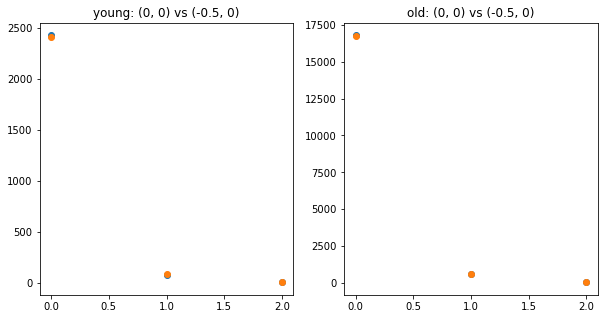

0    2430
1      79
2       5
Name: transit_multiplicity, dtype: int64
0    2418
1      90
2       6
Name: transit_multiplicity, dtype: int64
0    16782
1      618
2       55
Name: transit_multiplicity, dtype: int64
0    16764
1      648
2       43
Name: transit_multiplicity, dtype: int64


In [41]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=[10,5])
ax = axes[0]
ax.scatter(a_young.transit_multiplicity.value_counts().index, a_young.transit_multiplicity.value_counts())
ax.scatter(b_young.transit_multiplicity.value_counts().index, b_young.transit_multiplicity.value_counts())
ax.set_title('young: (0, 0) vs (-0.5, 0)')

ax = axes[1]
ax.scatter(a_old.transit_multiplicity.value_counts().index, a_old.transit_multiplicity.value_counts())
ax.scatter(b_old.transit_multiplicity.value_counts().index, b_old.transit_multiplicity.value_counts())
ax.set_title('old: (0, 0) vs (-0.5, 0)')
plt.show()

print(a_young.transit_multiplicity.value_counts())
print(b_young.transit_multiplicity.value_counts())
print(a_old.transit_multiplicity.value_counts())
print(b_old.transit_multiplicity.value_counts())

In [50]:
a = pd.read_csv('young_old_test_data/transits10_0_1.csv')
b = pd.read_csv('young_old_test_data/transits10_5_1.csv')
a.planet_inclinations = a.planet_inclinations.apply(literal_eval)
a['num_planets'] = a.planet_inclinations.str.len()
b['num_planets'] = b.planet_inclinations.str.len()
a_young = a.loc[a.star_ages <= 1.]
a_old = a.loc[a.star_ages > 1.]
b_young = b.loc[b.star_ages <= 1.]
b_old = b.loc[b.star_ages > 1.]

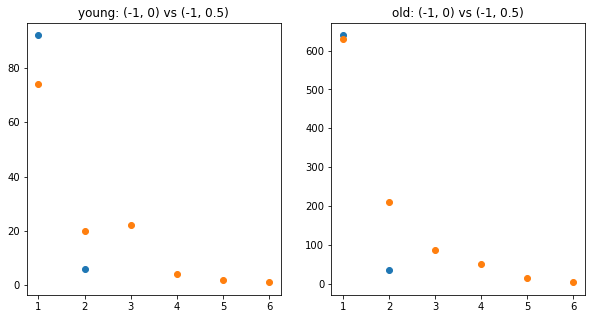

0    2416
1      92
2       6
Name: transit_multiplicity, dtype: int64
0    2391
1      74
3      22
2      20
4       4
5       2
6       1
Name: transit_multiplicity, dtype: int64
0    16782
1      639
2       34
Name: transit_multiplicity, dtype: int64
0    16463
1      629
2      209
3       86
4       50
5       15
6        3
Name: transit_multiplicity, dtype: int64


In [52]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=[10,5])
ax = axes[0]
ax.scatter(a_young.transit_multiplicity.value_counts().index[1:], a_young.transit_multiplicity.value_counts()[1:])
ax.scatter(b_young.transit_multiplicity.value_counts().index[1:], b_young.transit_multiplicity.value_counts()[1:])
ax.set_title('young: (-1, 0) vs (-1, 0.5)')

ax = axes[1]
ax.scatter(a_old.transit_multiplicity.value_counts().index[1:], a_old.transit_multiplicity.value_counts()[1:])
ax.scatter(b_old.transit_multiplicity.value_counts().index[1:], b_old.transit_multiplicity.value_counts()[1:])
ax.set_title('old: (-1, 0) vs (-1, 0.5)')
plt.show()

print(a_young.transit_multiplicity.value_counts())
print(b_young.transit_multiplicity.value_counts())
print(a_old.transit_multiplicity.value_counts())
print(b_old.transit_multiplicity.value_counts())

In [43]:
a.loc[a.star_ages < 0.5] # these are the stars with non-zero P(intact) in the (-1, 0.5) case; ~1% of FGK stars

,Unnamed: 0,star_ages,planet_periods,semi_major_axes,midplane,midplane_degrees,planet_inclinations,planet_inclinations_degrees,impact_parameters,transit_status,...,geometric_transit_multiplicity,transit_multiplicity,kepid,y_intercept,slope,transit_duration,6hr_cdpp,signal_noise,prob_detections,num_planets
68,68,0.27,[162.5515482879336],[0.6251395682083858],0.510860,[29.27011203386443],[0.6055240884509976],[34.69397466174852],[64.29729745948596],[0],...,0,0,1571732,0.0,-1.0,[nan],134.900,[nan],[0.],1
93,93,0.26,[44.12002551565295],[0.2572321909861424],0.591173,[33.87170914816407],[0.5346041646060227],[30.630562342042243],[25.43508795414203],[0],...,0,0,1718753,0.0,-1.0,[nan],44.813,[nan],[0.],1
111,111,0.46,[17.731612133578437],[0.14432012674101993],-0.034844,[-1.9964094626281557],[0.047700740838946695],[2.7330511297189712],[1.174410339940764],[0],...,0,0,1722816,0.0,-1.0,[nan],85.155,[nan],[0.],1
217,217,0.35,"[6.558508346427558, 229.54104374110082]","[0.07579368601534982, 0.8109670568359026]",-1.288254,[-73.81152183220662],"[-1.24855247522123, -1.2063006694036458]","[-71.53678733078878, -69.1159371806349]","[-11.756015598993375, -123.89923004479158]","[0, 0]",...,0,0,2019761,0.0,-1.0,[nan nan],163.566,[nan nan],[0. 0.],2
430,430,0.48,"[20.795310116692594, 8.6067798609867]","[0.16597033363657698, 0.09217518037576292]",-0.673829,[-38.60754787982303],"[-1.0185400570218903, -0.5717415755254114]","[-58.35804653236852, -32.75837924976627]","[-21.71803013635782, -7.666106957440752]","[0, 0]",...,0,0,2452289,0.0,-1.0,[nan nan],55.937,[nan nan],[0. 0.],2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19433,19433,0.30,"[175.50081643849077, 2.4370594207462744]","[0.6619762091774692, 0.038244327893418875]",-1.325207,[-75.92877373374868],"[-1.2168806986025746, -1.5470922375407101]","[-69.7221282008587, -88.64185572853371]","[-110.1682056556575, -6.7833696587454915]","[0, 0]",...,0,0,12024098,0.0,-1.0,[nan nan],35.270,[nan nan],[0. 0.],2
19517,19517,0.29,"[177.10027191802038, 2.460588401160656]","[0.6695057521354826, 0.03869315493012433]",0.323883,[18.557154949154953],"[0.43339771706388996, 0.41334396046334654]","[24.83186003836588, 23.68286442177212]","[49.07398383576416, 2.712689909653323]","[0, 0]",...,0,0,12107925,0.0,-1.0,[nan nan],31.147,[nan nan],[0. 0.],2
19658,19658,0.47,[22.129607086125663],[0.15721439796640715],0.038914,[2.2295903787178015],[0.0294371472911076],[1.6866243006854298],[0.9950122044266921],[1],...,1,1,12215836,0.0,-1.0,[0.04517283],57.862,[17.99971578],[1.],1
19672,19672,0.25,[48.9199398492239],[0.27936993245036906],0.300828,[17.236177957173943],[0.23986825135696302],[13.743438441937164],[12.219122420008446],[0],...,0,0,12251653,0.0,-1.0,[nan],54.232,[nan],[0.],1


In [44]:
df = pd.read_csv('young_old_test_data/transits5_10_1.csv')
df.planet_inclinations = df.planet_inclinations.apply(literal_eval)
df['num_planets'] = df.planet_inclinations.str.len()
df_young = df.loc[a.star_ages <= 1.]
df_old = df.loc[df.star_ages > 1.]

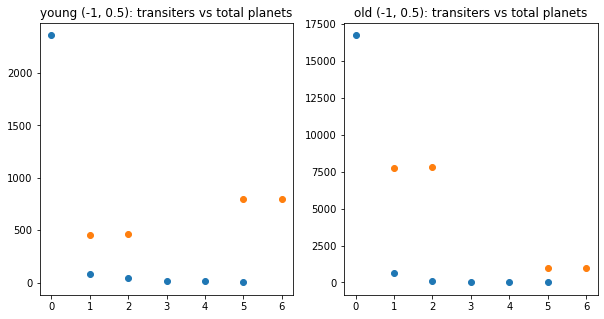

0    2359
1      81
2      42
3      17
4      14
5       1
Name: transit_multiplicity, dtype: int64
5    802
6    796
2    465
1    451
Name: num_planets, dtype: int64
0    16739
1      614
2       76
3       16
4        8
5        2
Name: transit_multiplicity, dtype: int64
2    7795
1    7735
6     974
5     951
Name: num_planets, dtype: int64


In [45]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=[10,5])
ax = axes[0]
ax.scatter(df_young.transit_multiplicity.value_counts().index, df_young.transit_multiplicity.value_counts())
ax.scatter(df_young.num_planets.value_counts().index, df_young.num_planets.value_counts())
ax.set_title('young (-1, 0.5): transiters vs total planets')

ax = axes[1]
ax.scatter(df_old.transit_multiplicity.value_counts().index, df_old.transit_multiplicity.value_counts())
ax.scatter(df_old.num_planets.value_counts().index, df_old.num_planets.value_counts())
ax.set_title('old (-1, 0.5): transiters vs total planets')
plt.show()

print(df_young.transit_multiplicity.value_counts())
print(df_young.num_planets.value_counts())
print(df_old.transit_multiplicity.value_counts())
print(df_old.num_planets.value_counts())